# MetPy
- Python toolkit for Meteorology
    - Reading in weather data formats (currently NEXRAD Levels 2 and 3 data)
    - Re-usable calculation routines
    - Weather plots
- Intended for use by anyone in the field: Education, Research, etc.

Design philosophy:
- Fit well with the rest of the scientific Python ecosystem (NumPy, Matplotlib, etc.)
- Simple to use with your own data
- Unit correctness built-in (using `pint`)
- Well-tested and documented

## Unit Support and Constants

- Unit support in MetPy comes from a package called `pint`, which provides a unit registry of all the units it knows about.
- The registry also provides a `Quantity` object that wraps `numpy` arrays to provide unit-aware math operations.
- MetPy also contains a set of constants with units attached in the `metpy.constants` [module](https://metpy.readthedocs.org/en/latest/api/constants.html) .

### Quick Demo

In [1]:
# Simple example. The units name imported here is the registry.
from metpy.units import units
import metpy.constants as consts
dist = 10 * units.miles
time = 15 * units.minutes
avg_speed = dist / time
avg_speed

<Quantity(0.6666666666666666, 'mile / minute')>

In [2]:
# Convert to something more meaningful to me
avg_speed.to(units.mph)

<Quantity(40.0, 'mph')>

Can also give `pint` a unit expression that it parses:

In [3]:
avg_speed.to('m/s')

<Quantity(17.8816, 'meter / second')>

Could also do something a bit more useful for physics:

In [4]:
m = 102 * units.kg
a = 9.81 * units('m/s^2')
F = m * a
F.to('N')

<Quantity(1000.62, 'newton')>

### Attaching units
Variety of ways to add units:

In [5]:
3e8 * units.meter / units.second

<Quantity(300000000.0, 'meter / second')>

In [6]:
3e8 * units('m/s')

<Quantity(300000000.0, 'meter / second')>

In [7]:
units.Quantity(3e8, units.m / units.sec)

<Quantity(300000000.0, 'meter / second')>

In [8]:
units.Quantity(3e8, 'm/s')

<Quantity(300000000.0, 'meter / second')>

### Temperature support
One of the factors that led to the choice of `pint` was the fact that it supports temperature units, both changes in temperature and absolute temperature values (which are not strictly multiplicative).

In [9]:
T = 30 * units.degF
P = 500 * units.mbar
P0 = 1000 * units.mbar
T * (P0 / P) ** consts.kappa

<Quantity(331.6523976628072, 'kelvin')>

- MetPy uses pint in its more flexible mode for temperature support
- This automatically converts temperatures with an offset (i.e. Farenheit/Celsius) to the base unit
- This mode allows the use of temperatures in these units in calculations, as well as the standard construction syntax
- However, this also allows things like the following:

In [10]:
T * 2

<Quantity(60, 'degF')>

In [11]:
(T * (1000 / 500) ** consts.kappa).to('K')

<Quantity(275.6911550324745, 'kelvin')>

### Exercises

What's the density of air at 925 mb and 82 F?

$$P = \rho R T$$

$R$ for dry air is in ``metpy.constants`` as ``Rd``.

Bigger problem: How much energy does it take to raise the temperature of liquid water:

$$Q = c_p m \Delta T$$

Assume: 60 kg of water, from 32F to 85F. $C_p$ for liquid water is in `metpy.constants` as `Cp_l`.

## Calculation functions

- Provides a wide array of sets of calculations:
  - Basic calculation: wind components, heat index, ...
  - Thermodynamic: potential temperature, LCL, ...
  - Kinematic: Convergence, vorticity, ...
  - Turbulence: TKE, kinematic flux, ...
- Extensively uses units support to ensure dimensional correctness
- Exhaustively [documented](https://metpy.readthedocs.org/en/latest/api/calc.html).

It's 86F outside here (pressure 860 mb), with a relative humidity of 40%. What's the dewpoint?

In [12]:
import metpy.calc as mcalc
temp = 86 * units.degF
press = 860. * units.mbar
humidity = 40 / 100.

In [13]:
dewpt = mcalc.dewpoint_rh(temp, humidity).to('degF')
dewpt

<Quantity(58.904391157249485, 'degF')>

What's the water vapor mixing ratio for those conditions?

In [14]:
e = mcalc.saturation_vapor_pressure(dewpt)
mcalc.mixing_ratio(e, press).to('g/kg')

<Quantity(12.52765353349236, 'gram / kilogram')>

MetPy also has more sounding-focused calculations. For instance, what's the lifted condensation level (LCL) for those conditions?

In [15]:
mcalc.lcl(press, temp, dewpt)

<Quantity(690.7279935805985, 'millibar')>

Or we can even calculate the parcel profile (temperature at a series of pressure levels) for those conditions:

In [16]:
import numpy as np
pressure_levels = np.array([860., 850., 700., 500., 300.]) * units.mbar
mcalc.parcel_profile(pressure_levels, temp, dewpt)

<Quantity([ 303.14999978  302.13813484  285.82594985  272.21678105  247.74142449], 'kelvin')>

### Exercise

It's 95F outside with a dewpoint of 70F. What's the heat index?

Note: $RH = e / e_s$

## Skew-T

- Skew-T is the only plotting function in MetPy currently...
- But it's an important one
- Based on matplotlib, so it integrates with other plots
- Can use matplotlib plots like `axvline` directly

In [17]:
from siphon.catalog import TDSCatalog
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p5deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p5deg/Best')
best_ds = list(best_gfs.datasets.values())[0]

In [18]:
# Set up a class to access
from siphon.ncss import NCSS
ncss = NCSS(best_ds.access_urls['NetcdfSubset'])

# Get today's date
from datetime import datetime, timedelta
now = datetime.utcnow()

# Re-use the NCSS access from earlier, but make a new query
query = ncss.query()
query.lonlat_point(-105, 40).time(now + timedelta(hours=12)).accept('csv')
query.variables('Temperature_isobaric', 'Relative_humidity_isobaric',
                'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')

data = ncss.get_data(query)

In [19]:
# Pull out data with some units. Reversing arrays to put higher pressure first.
p = (data['vertCoord'][::-1] * units('Pa')).to('mbar')
T = data['Temperature_isobaric'][::-1] * units('kelvin')
Td = mcalc.dewpoint_rh(T, data['Relative_humidity_isobaric'][::-1] / 100.)
u = data['ucomponent_of_wind_isobaric'][::-1] * units('m/s')
v = data['vcomponent_of_wind_isobaric'][::-1] * units('m/s')

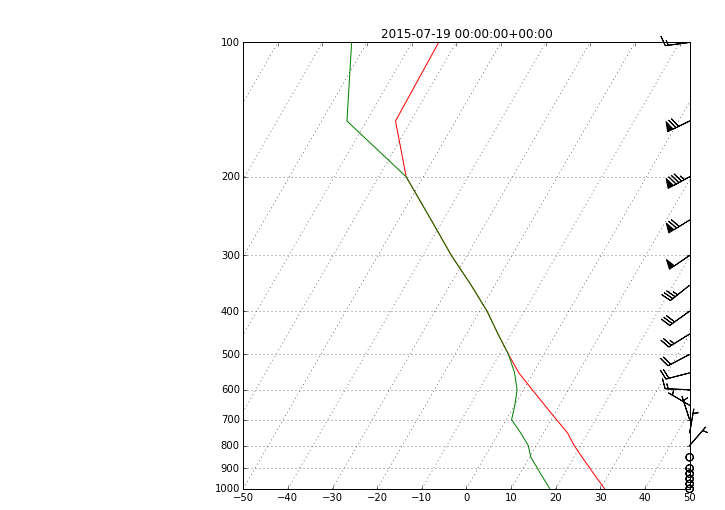

In [20]:
# Create a skewT using matplotlib's default figure size
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(8, 8))

from metpy.plots import SkewT
skew = SkewT(fig)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T.to('degC'), 'r')
skew.plot(p, Td.to('degC'), 'g')

skew.plot_barbs(p, u.to('knots'), v.to('knots'))
skew.ax.set_ylim(1000, 100)
skew.ax.set_title(data['time'][0]);

Nice, but we could use some of the typical lines:
- Dry Adiabats
- Moist Adiabats
- Mixing ratio lines (isohume)

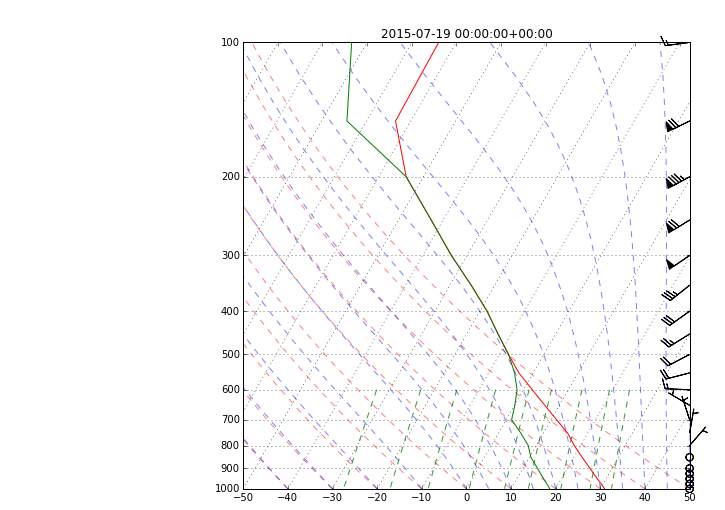

In [21]:
# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()
fig

Can also use "vertical" lines to highlight isotherms.

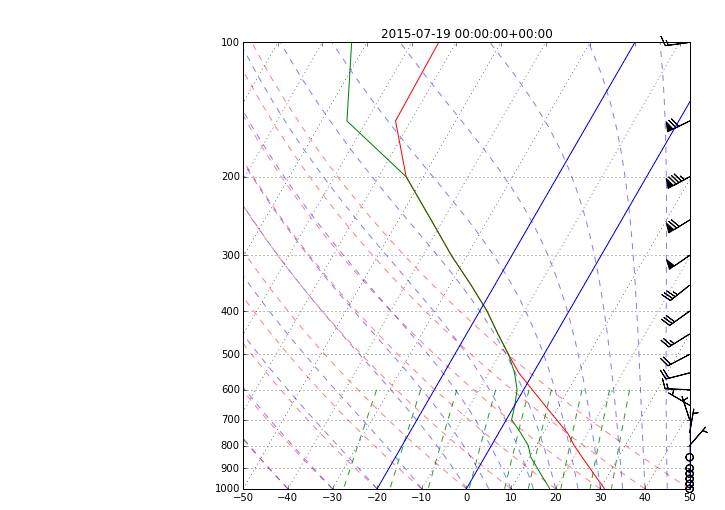

In [22]:
skew.ax.axvline(0)
skew.ax.axvline(-20)
fig

Or plot the parcel profile on the Skew-T

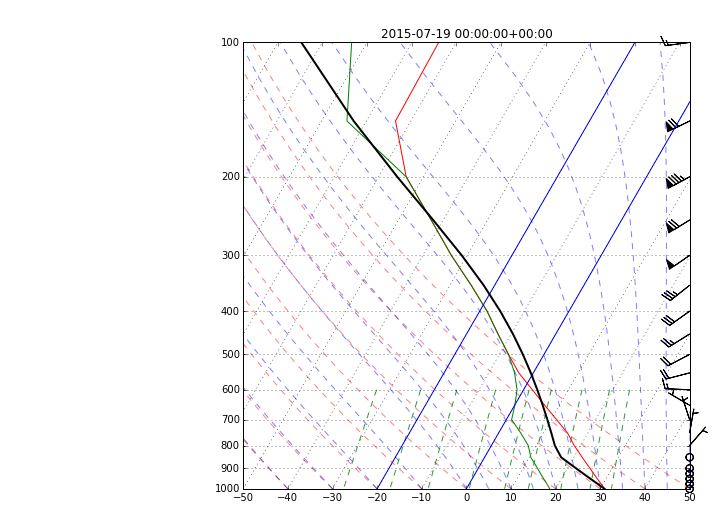

In [23]:
prof = mcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2)
fig

And can use matplotlib to fill the positive and negative areas.

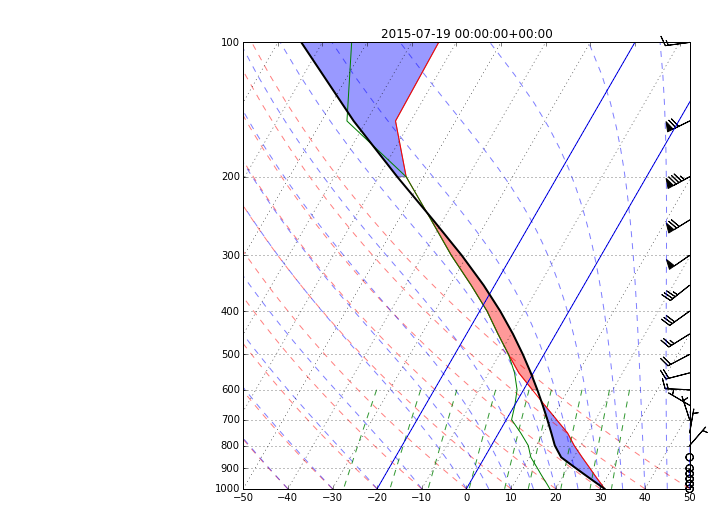

In [24]:
skew.ax.fill_betweenx(p, T.to('degC'), prof, where=T>=prof, facecolor='blue', alpha=0.4)
skew.ax.fill_betweenx(p, T.to('degC'), prof, where=T<prof, facecolor='red', alpha=0.4)
fig

### Exercise

Plot a different sounding from the HRRR:

In [25]:
from siphon.catalog import TDSCatalog
best_hrrr = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/'
                       'HRRR/CONUS_2p5km/catalog.html?dataset=grib/NCEP/HRRR/CONUS_2p5km/Best')
best_ds = list(best_gfs.datasets.values())[0]

from siphon.ncss import NCSS
ncss = NCSS(best_ds.access_urls['NetcdfSubset'])

query = ncss.query()
query.lonlat_point(-105, 40).time(now + timedelta(hours=12)).accept('csv')
query.variables('Temperature_isobaric', 'Relative_humidity_isobaric',
                'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')

data = ncss.get_data(query)

# Pull out data with some units. Reversing arrays to put higher pressure first.
p = (data['vertCoord'][::-1] * units('Pa')).to('mbar')
T = data['Temperature_isobaric'][::-1] * units('kelvin')
Td = mcalc.dewpoint_rh(T, data['Relative_humidity_isobaric'][::-1] / 100.)
u = data['ucomponent_of_wind_isobaric'][::-1] * units('m/s')
v = data['vcomponent_of_wind_isobaric'][::-1] * units('m/s')

In [26]:
# Plot the sounding here

# Add some of the standard lines

# Highlight the -10C isotherm with a blue dashed line

# If you're really feeling ambitious, plot the parcel profile, or the LCL.

## Coming Soon

### Station Plots

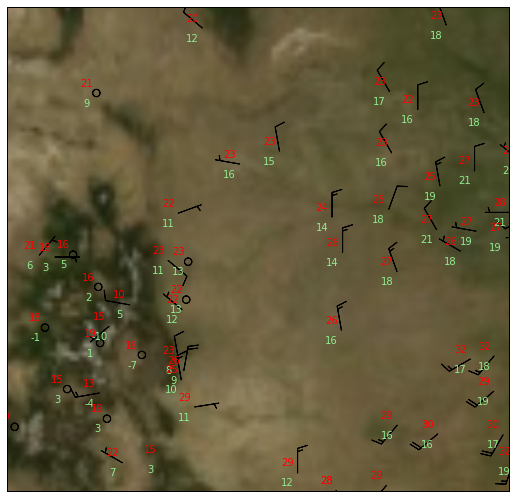

In [27]:
from IPython.display import Image
Image('images/station-plot.png')

### Hodograph

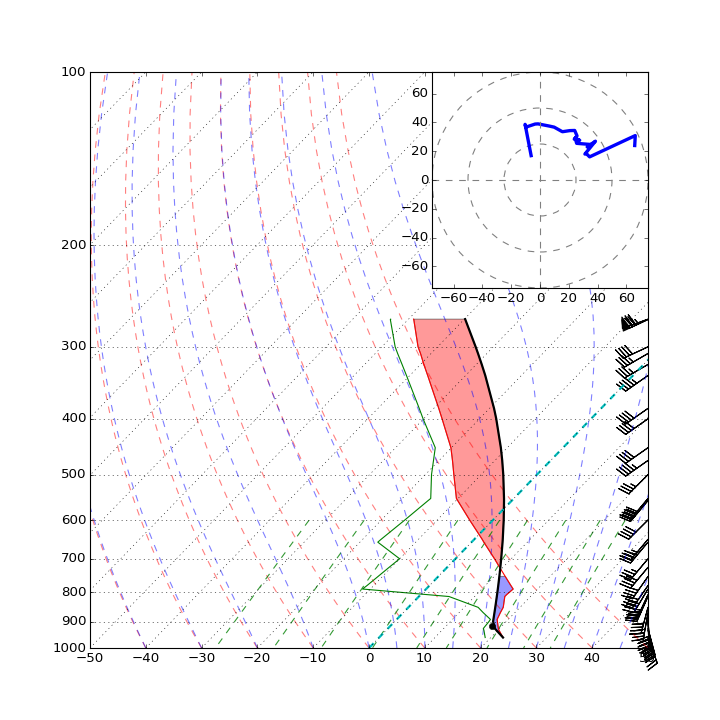

In [28]:
Image('images/hodograph.png')

### Radar Plots

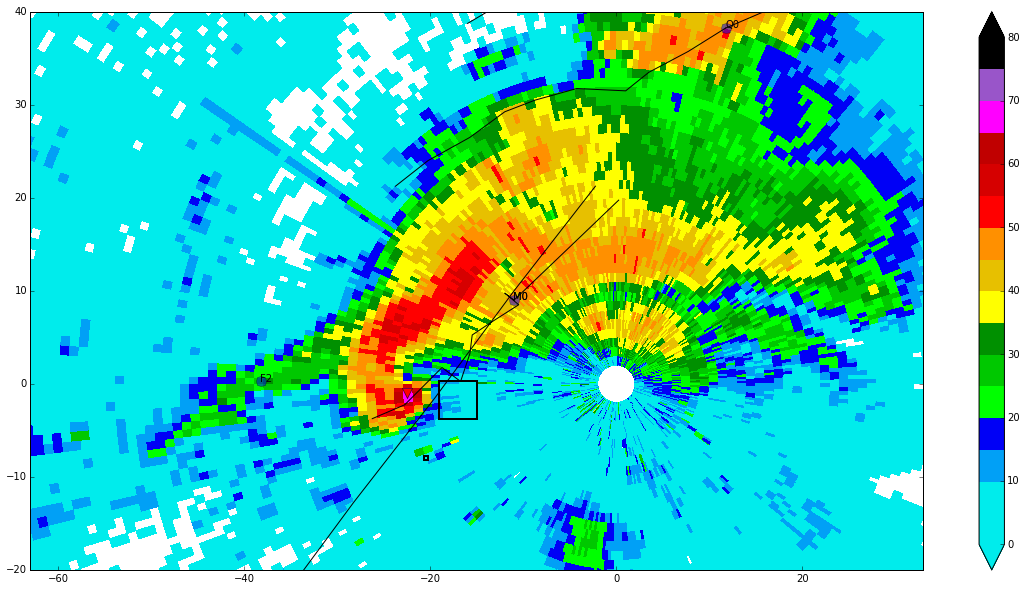

In [29]:
Image('images/radar-plots.png')

## Participation

### Getting and using MetPy
MetPy is open-source and all development done in the open:
- Supports Python 2.7 and >= 3.2
- Source available on [GitHub](https://github.com/metpy/MetPy)
- The GitHub [Issue Tracker](https://github.com/metpy/MetPy/issues) is used extensively
- Documetation is [online](http://metpy.rtfd.org)

### Join Us!
We want to encourage everyone to join us in making MetPy as useful as possible:
- Wrote something cool that you think everyone could benefit from?
    - Open a Pull Request!
    - Even if it's not completely up to snuff (tests, docs) we'll be happy to help you get it there.

- Found MetPy useful but it's missing one piece that would help you achieve inner peace?
    - Create a new issue!
    - Or even better yet, take a stab at making it and open a Pull Request.

- Made some really cool plots with MetPy?
    - We **love** examples -- send it to us!
    - Or better yet, add it to the examples and open a Pull Requst!